[IPython Notebook](backend.ipynb) |  [Python Script](backend.py)

Advanced: Digging into the Backend
============================

Setup
-----------------------------

As always, let's do imports and initialize a logger and a new Bundle.  See [Building a System](building_a_system.html) for more details.

In [1]:
%matplotlib inline

In [2]:
import phoebe
from phoebe import u # units
import numpy as np
import matplotlib.pyplot as plt

logger = phoebe.logger()

b = phoebe.default_binary()
b['q'] = 0.8
b['ecc'] = 0.05

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


/usr/local/lib/python2.7/dist-packages/astropy/units/quantity.py:732: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  return super(Quantity, self).__eq__(other)


And we'll attach some dummy datasets.  See [Datasets](datasets.html) for more details.

In [3]:
b.add_dataset(phoebe.dataset.orb, times=np.linspace(0,40,1000), dataset='orb01', component=['primary', 'secondary'])

times, fluxes, sigmas = np.loadtxt('test.lc.in', unpack=True)
b.add_dataset(phoebe.dataset.lc, times=times, fluxes=fluxes, sigmas=sigmas, dataset='lc01')

<ParameterSet: 12 parameters | kinds: lc, lc_dep>

From the Bundle
-----------------------------------

There is a middle-layer that translates the system in the Bundle into
the parameters (with correct units) required by the backend functions
themselves and returns the results (again with units).  

Interaction with this middle-layer is much nicer than manually building
the system hierarchy, but doesn't avoid the overhead introduced by the frontend.

### Dynamics

Let's say that you want to access (without adding a dataset) the dynamics
packages for the system you have setup in the Bundle.

First we'll look at Nbody dynamics, and later show the same for Keplerian.

In [4]:
b.add_compute(compute='default_options')

<ParameterSet: 25 parameters | datasets: lc01, orb01>

In [5]:
ts, xs, ys, zs, vxs, vys, vzs =\
    phoebe.dynamics.nbody.dynamics_from_bundle(b, np.linspace(0, 20, 500), compute='default_options')

The first returned item is an array of times - not surprisingly these match the times we just sent.

The rest of the returned items (xs, ys, etc) are each a list of arrays.  The list contains an entry for each component in the system.  So in this case, since we have a binary, each is a list of two arrays.

Now we can plot any of this information by pulling the correct array from these lists.

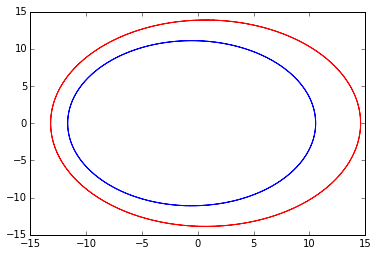

In [6]:
artist, = plt.plot(xs[0], zs[0], 'b-') # primary
artist, = plt.plot(xs[1], zs[1], 'r-') # secondary

For Keplerian dynamics, there is an additional option whether to return the Euler angles as well.  Since we'll later be using these to place the mesh in orbit, we'll set this to True.

In [7]:
ts, xs, ys, zs, vxs, vys, vzs, ethetas, elongans, eincls =\
    phoebe.dynamics.keplerian.dynamics_from_bundle(b, np.linspace(0, 6, 500), return_euler=True)

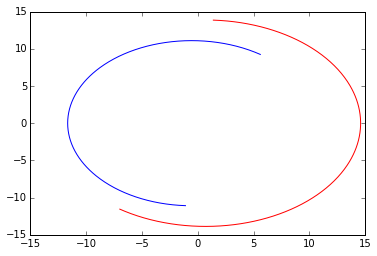

In [8]:
plt.cla()
artist, = plt.plot(xs[0], zs[0], 'b-') # primary
artist, = plt.plot(xs[1], zs[1], 'r-') # secondary

### Meshing

Similarly, we can create a backend "system" directly from the Bundle

In [9]:
system = phoebe.backend.universe.System.from_bundle(b)

This "system" object is just a container of multiple "bodies" which are also accessible

In [10]:
print system.bodies

[<phoebe.backend.universe.Star object at 0x7f729db88bd0>, <phoebe.backend.universe.Star object at 0x7f729db284d0>]


First we need to initialize the mesh "standard".  By default this is done at periastron and stores a copy of each unscaled mesh at periastron.  This mesh is later scaled, placed in orbit, and reprojected if necessary (for volume conservation in eccentric orbits, for example).

In [11]:
system.initialize_meshes()

These standards can then be accessed:

In [12]:
system.bodies[0].get_standard_mesh(scaled=False)

In [13]:
system.bodies[0].get_standard_mesh(scaled=True)

We then simply need to pass positions, velocities, and euler angles *at a given time* to have the meshes scaled and placed in orbit for us.

From the dynamics, we have lists of arrays.  So for the first time, we want ts[0] and xs[:,0], etc.

In [14]:
xi, yi, zi, vxi, vyi, vzi, ethetai, elongani, eincli = phoebe.dynamics.dynamics_at_i(xs, ys, zs, vxs, vys, vzs, ethetas, elongans, eincls, i=0)


In [15]:
system.update_positions(ts[0], xi, yi, zi,
                        vxi, vyi, vzi,
                        ethetai, eincli, elongani)

The meshes are now placed in orbit at the current time.  These meshes are accessible via:

In [16]:
system.meshes

which acts like a dictionary to get a mesh from a single component (if desired)

In [17]:
system.meshes.keys()

['primary', 'secondary']

We can pull any column out of the mesh in a similar dictionary style (with an entry for each component)

In [18]:
system.meshes.get_column('teffs')

{'primary': array([ 5999.8617327 ,  5999.86200662,  5999.8617327 , ...,  6000.05540866,
         6000.04555688,  6000.03085122]),
 'secondary': array([ 5999.79535632,  5999.7956988 ,  5999.79535632, ...,  6000.0730927 ,
         6000.0586651 ,  6000.03773153])}

or as a single flat array

In [19]:
system.meshes.get_column_flat('teffs')

array([ 5999.8617327 ,  5999.86200662,  5999.8617327 , ...,  6000.0730927 ,
        6000.0586651 ,  6000.03773153])

Note that the column names are not identical to those exposed in the frontend (since tags do not exist in the backend).  To access the list of available keys in the mesh, we can directly inspect the mesh.

In [20]:
system.meshes['primary'].keys()

['pvertices',
 'vertices',
 'triangles',
 'centers',
 'coords_for_computations',
 'normals_for_computations',
 'rs',
 'rprojs',
 'cosbetas',
 'areas',
 'tareas',
 'areas_si',
 'velocities',
 'vnormals',
 'tnormals',
 'normgrads',
 'volume',
 'phis',
 'thetas',
 'env_comp',
 'env_comp3',
 'compute_at_vertices',
 'loggs',
 'gravs',
 'teffs',
 'abuns',
 'frac_refls',
 'mus',
 'visibilities',
 'weights',
 'observables']

update_positions places the meshes in their orbits, handles volume conservation (for eccentric orbits), and computes instantaneous physical quantities (teff, logg, etc), but does **NOT** handle eclipse detection or subdivision.

We can now update the 'visibility' column by running eclipse detection.

In [21]:
system.handle_eclipses(eclipse_alg='graham', subdiv_num=1)

[array([[ -1.72108702e+00,   7.92910536e-01,  -1.10733717e+01],
        [ -1.67440105e+00,   8.25186001e-01,  -1.11381115e+01],
        [ -1.63879722e+00,   8.49696015e-01,  -1.10482217e+01],
        [ -1.58841646e+00,   8.77431404e-01,  -1.11425877e+01],
        [ -1.54987209e+00,   8.98532228e-01,  -1.10530794e+01],
        [ -1.51866062e+00,   9.12296233e-01,  -1.11339158e+01],
        [ -1.47890518e+00,   9.29584483e-01,  -1.10441306e+01],
        [ -1.44867580e+00,   9.41476544e-01,  -1.11127901e+01],
        [ -1.35843187e+00,   9.69770052e-01,  -1.10842159e+01],
        [ -1.26801620e+00,   9.88507289e-01,  -1.10731845e+01],
        [ -1.16577157e+00,   9.99129177e-01,  -1.11067720e+01],
        [ -1.08898800e+00,   1.00040273e+00,  -1.10545800e+01],
        [ -1.01116748e+00,   9.95594158e-01,  -1.11204867e+01],
        [ -9.41230042e-01,   9.85989813e-01,  -1.10500455e+01],
        [ -8.99032231e-01,   9.77782187e-01,  -1.11253347e+01],
        [ -8.67030492e-01,   9.69442459e

We can easily check to make sure an eclipse happened by computing the ratio of triangles for each component that are currently visible.

In [22]:
visibilities = system.meshes.get_column('visibilities')
print "primary visibility:", visibilities['primary'].sum() / len(visibilities['primary'])
print "secondary visibility:", visibilities['secondary'].sum() / len(visibilities['secondary'])

primary visibility: 0.488934066422
secondary visibility: 0.510197960408


Without the Bundle
-----------------------

Now let's look at how we would setup the backend without a bundle.  Once created, all of the capabilities described above are also available.

### Dynamics

Dynamics without the bundle is *nearly* as simple, but special care needs to be made with passing values in the right units.

Once again, let's look at Nbody first and then Keplerian.

In [23]:
times = np.linspace(0,10,500) # days
masses = [1.0, 0.8] # solar masses
smas = [1.0, 1.0] # AU
eccs = [0.8, 0.8] # unitless
incls = [np.pi/2, np.pi/2] # radians
per0s = [0, 0] # radians
long_ans = [0, 0] # radians
mean_anoms = [0, 0]
t0 = 0.0 # days

In [24]:
ts, xs, ys, zs, vxs, vys, vzs =\
    phoebe.dynamics.nbody.dynamics(times, masses, smas,
                                    eccs, incls, per0s,
                                    long_ans, mean_anoms,
                                    t0, stepsize=0.01,
                                    gr=False, 
                                    ltte=False)

In [25]:
xi, yi, zi, vxi, vyi, vzi, ethetai, elongani, eincli = phoebe.dynamics.dynamics_at_i(xs, ys, zs, vxs, vys, vzs, ethetas, elongans, eincls, i=0)

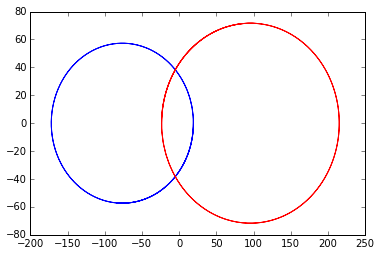

In [26]:
artist, = plt.plot(xs[0], zs[0], 'b-') # primary
artist, = plt.plot(xs[1], zs[1], 'r-') # secondary

Now let's look at Keplerian dynamics.  Here we need to provide information for the parent orbit of **each star**.  In the case of a simple binary, this can seem quite redundant.

In [27]:
times = np.linspace(0,10,500) # days
periods = [3.0, 3.0] # days
eccs = [0.0, 0.0]
smas = [1.0, 0.8] # Rsol (sma of the STAR about the CENTER OF MASS)
t0_perpasses = [0.0, 0.0] # days
per0s = [0.0, 0.0] # radians
long_ans = [0.0, 0.0] # radians
incls = [np.pi/2, np.pi/2] # radians
dpdts = [0.0, 0.0] # days/day
deccdts = [0.0, 0.0] # 1/day
dperdts = [0.0, 0.0] # radians/day
components = ['primary', 'secondary']
t0 = 0.0 # days
vgamma = 0.0 # solRad/day (TODO: double check!!!)

In [28]:
ts, xs, ys, zs, vxs, vys, vzs, ethetas, elongans, eincls =\
    phoebe.dynamics.keplerian.dynamics(times, periods,
                                        eccs, smas, t0_perpasses,
                                        per0s, long_ans, incls,
                                        dpdts, deccdts, dperdts,
                                        components,
                                        t0, vgamma=vgamma,
                                        ltte=False,
                                        return_euler=True)

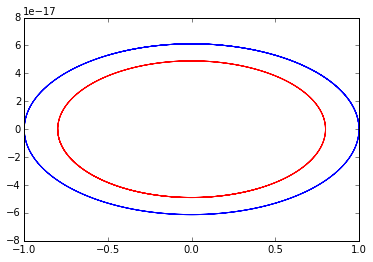

In [29]:
plt.cla()
artist, = plt.plot(xs[0], ys[0], 'b-') # primary
artist, = plt.plot(xs[1], ys[1], 'r-') # secondary

### Meshing

In [30]:
F = 1.0
Phi = 9.5
masses = [1.0, 0.8]  # solar Masses
sma = 8.0   # solar radii
ecc = 0.0
freq_rot = 2*np.pi/1  # radians/day
abun = 0.0
alb_ref = 0.0
teff = 6000  # K
gravb_bol = 0.2
gravb_law = 'zeipel'

In [31]:
primarymesh = phoebe.backend.universe.Star(F, Phi, masses, sma, ecc,
                                           freq_rot, teff, gravb_bol,
                                           abun, alb_ref,
                                           delta=0.1, maxpoints=1e5,
                                           ind_self=0,
                                           ind_sibling=1,
                                           comp_no=1)

In [32]:
secondarymesh = primarymesh.copy()

In [33]:
system = phoebe.backend.universe.System({'primary': primarymesh, 'secondary': secondarymesh})

Now that the "system" object is created, see the section in the "From the Bundle" section for details on initializing the meshes, placing them in orbit, eclipse detection, and accessing columns.

In [34]:
system.initialize_meshes()

In [35]:
system.update_positions(ts, xi, yi, zi,
                        vxi, vyi, vzi,
                        ethetai, eincli, elongani)

In [36]:
system.handle_eclipses(eclipse_alg='graham')

/home/kyle/.local/lib/python2.7/site-packages/phoebe/backend/eclipse.py:14: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  hull, inside = ceclipse.graham_scan_inside_hull(front[sa], back)
/home/kyle/.local/lib/python2.7/site-packages/phoebe/backend/eclipse.py:14: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  hull, inside = ceclipse.graham_scan_inside_hull(front[sa], back)
/home/kyle/.local/lib/python2.7/site-packages/phoebe/backend/eclipse.py:14: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  hull, inside = ceclipse.graham_scan_inside_hull(front[sa], back)
/home/kyle/.local/lib/python2.7/site-packages/phoebe/backend/eclipse.py:14: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  hull, inside = ceclipse.graham_scan_inside_hull(front[sa], back)
